In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 
from sklearn.preprocessing import MinMaxScaler

In [32]:
import pandas_datareader as web
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [33]:
from datetime import datetime
import yfinance as yf

In [34]:
df = yf.download('aapl', start = '2010-01-01', end = '2022-01-01')

[*********************100%***********************]  1 of 1 completed


In [35]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526476,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422665,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410793,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453412,447610800
...,...,...,...,...,...,...
2021-12-27,177.089996,180.419998,177.070007,180.330002,179.289444,74919600
2021-12-28,180.160004,181.330002,178.529999,179.289993,178.255432,79144300
2021-12-29,179.330002,180.630005,178.139999,179.380005,178.344925,62348900


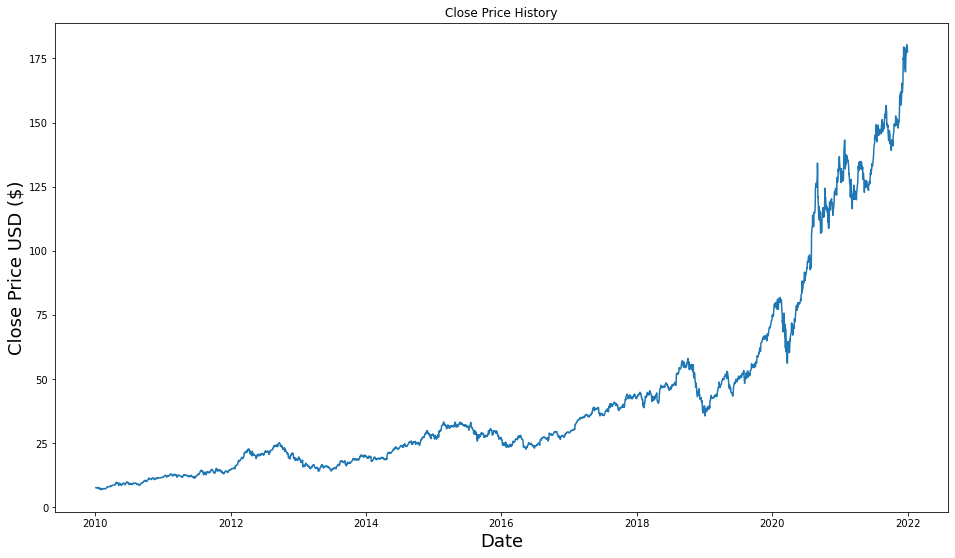

In [36]:
plt.figure(figsize=(16,9))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.show()

In [37]:
data = df.filter(['Close']) # only using the close prices
dataset = data.values

In [38]:
training_data_len = math.ceil(len(dataset)*0.8) # taking first 80% of the data chronologically
training_data_len # for training

2417

In [39]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset) # scaling

In [40]:
train_data = scaled_data[0:training_data_len, :]

x_train = [] # we will take 30 days value to predict the value on 31st day
y_train = [] # will only store values every 31 days

for i in range(30, len(train_data)):
    x_train.append(train_data[i-30:i, 0])
    y_train.append(train_data[i,0])

In [41]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [42]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [43]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(5))
model.add(Dense(1)) # specifying the ANN layers

In [44]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [45]:
model.fit(x_train, y_train, batch_size = 1, epochs = 1) # fitting the model

2387/2387 [==============================] - 29s 11ms/step - loss: 1.3910e-04


In [46]:
test_data = scaled_data[training_data_len - 30: , :] 

# we can use the last 30 rows of training data to predict the first day of test data

In [47]:
x_test = [] 
y_test = dataset[training_data_len:, :] # we will predict prices for the last 20% of data
for i in range(30, len(test_data)):
    x_test.append(test_data[i-30:i, 0]) # appending the test data, skipping one day after 30 days

In [48]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [49]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # predicting the price

19/19 [==============================] - 1s 7ms/step


In [50]:
rmse = np.sqrt( np.mean(predictions - y_test)**2)
rmse  # root mean-squared error

7.549185449713903

In [51]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions


/var/folders/3w/9sxng9vs07x5y5pwg23csg4r0000gn/T/ipykernel_27931/3011436284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


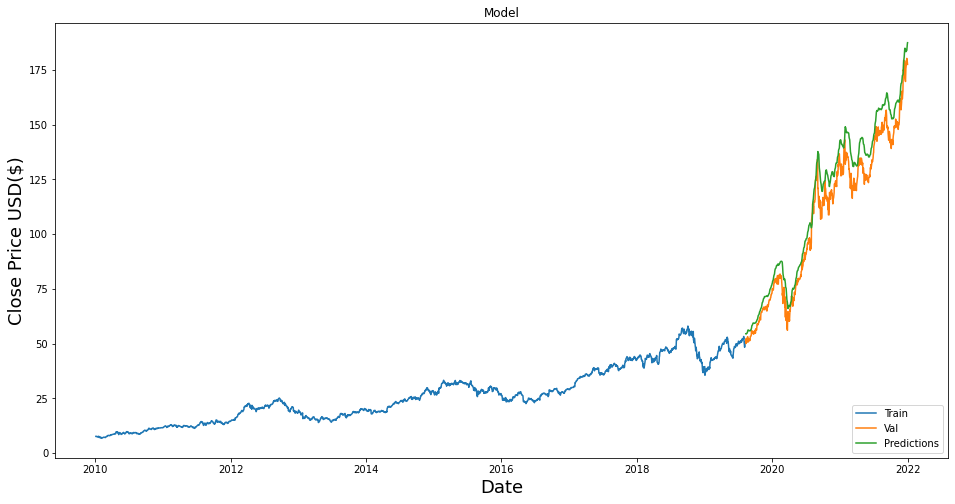

In [52]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD($)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.show() 

In [53]:
valid

,Close,Predictions
Date,,
2019-08-12,50.119999,54.441597
2019-08-13,52.242500,54.345795
2019-08-14,50.687500,54.544075
2019-08-15,50.435001,54.657642
2019-08-16,51.625000,54.688255
...,...,...
2021-12-27,180.330002,183.959961
2021-12-28,179.289993,185.022232
2021-12-29,179.380005,186.039581


In [85]:
df1 = yf.download('aapl', start = '2022-01-01', end = '2022-8-14') # getting the train data

[*********************100%***********************]  1 of 1 completed


In [86]:
new_df = df1.filter(['Close'])

last_30_days = new_df[-30:].values # keeping on the last 30 days worth of vaalue

In [87]:
new_df = df1.filter(['Close'])

last_30_days = new_df[-30:].values

last_30_days_scaled = scaler.transform(last_30_days)

X_test = []

X_test.append(last_30_days_scaled)

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)

pred_price = scaler.inverse_transform(pred_price)



1/1 [==============================] - 0s 20ms/step


In [88]:
pred_price # predicted price

array([[177.40938]], dtype=float32)

In [89]:
df_x = yf.download('aapl', start = '2022-01-01', end = '2022-8-15')

[*********************100%***********************]  1 of 1 completed


In [90]:
df_x['Close'][-1] # actual price

172.10000610351562